# Image Captioning with RNNs
In this exercise you will implement a vanilla recurrent neural networks and use them it to train a model that can generate novel captions for images.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Install h5py
The COCO dataset we will be using is stored in HDF5 format. To load HDF5 files, we will need to install the `h5py` Python package. From the command line, run: <br/>
`pip install h5py`  <br/>
If you receive a permissions error, you may need to run the command as root: <br/>
```sudo pip install h5py```

You can also run commands directly from the Jupyter notebook by prefixing the command with the "!" character:

In [2]:
!pip install h5py

'pip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


# Microsoft COCO
For this exercise we will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

You should have already downloaded the data by changing to the `cs231n/datasets` directory and running the script `get_assignment3_data.sh`. If you haven't yet done so, run that script now. Warning: the COCO data download is ~1GB.

We have preprocessed the data and extracted features for you already. For all images we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet; these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5` respectively. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512; these features can be found in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`.

The raw images take up a lot of space (nearly 20GB) so we have not included them in the download. However all images are taken from Flickr, and URLs of the training and validation images are stored in the files `train2014_urls.txt` and `val2014_urls.txt` respectively. This allows you to download images on the fly for visualization. Since images are downloaded on-the-fly, **you must be connected to the internet to view images**.

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `cs231n/coco_utils.py` to convert numpy arrays of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

You can load all of the MS-COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `cs231n/coco_utils.py`. Run the following cell to do so:

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `cs231n/coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function and that we download the images on-the-fly using their Flickr URL, so **you must be connected to the internet to view images**.

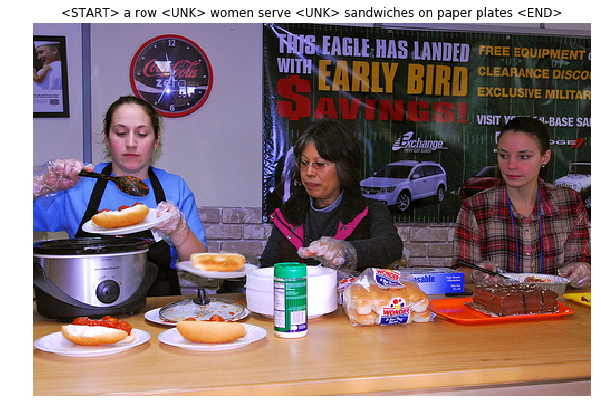

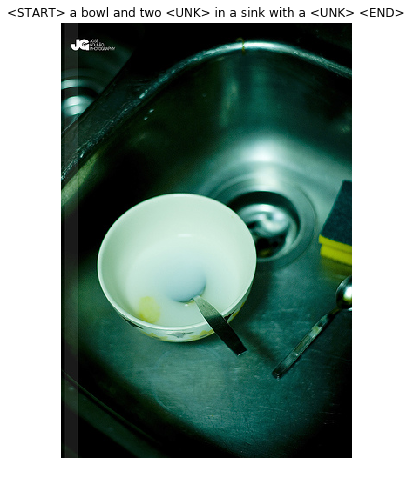

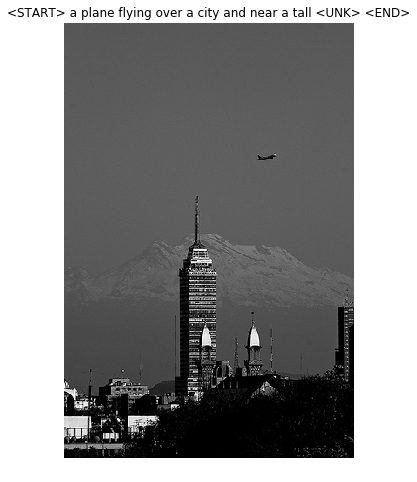

In [6]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Networks
As discussed in lecture, we will use recurrent neural network (RNN) language models for image captioning. The file `cs231n/rnn_layers.py` contains implementations of different layer types that are needed for recurrent neural networks, and the file `cs231n/classifiers/rnn.py` uses these layers to implement an image captioning model.

We will first implement different types of RNN layers in `cs231n/rnn_layers.py`.

# Vanilla RNN: step forward
Open the file `cs231n/rnn_layers.py`. This file implements the forward and backward passes for different types of layers that are commonly used in recurrent neural networks.

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors less than 1e-8.

In [22]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.29242142647e-09


# Vanilla RNN: step backward
In the file `cs231n/rnn_layers.py` implement the `rnn_step_backward` function. After doing so run the following to numerically gradient check your implementation. You should see errors less than `1e-8`.

In [6]:
from cs231n.rnn_layers import rnn_step_forward, rnn_step_backward
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.32752659079e-10
dprev_h error:  2.28525513254e-10
dWx error:  5.46145452965e-10
dWh error:  1.80240958315e-09
db error:  8.74487352004e-11


# Vanilla RNN: forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that process an entire sequence of data.

In the file `cs231n/rnn_layers.py`, implement the function `rnn_forward`. This should be implemented using the `rnn_step_forward` function that you defined above. After doing so run the following to check your implementation. You should see errors less than `1e-7`.

In [7]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.72846611454e-08


# Vanilla RNN: backward
In the file `cs231n/rnn_layers.py`, implement the backward pass for a vanilla RNN in the function `rnn_backward`. This should run back-propagation over the entire sequence, calling into the `rnn_step_backward` function that you defined above. You should see errors less than 5e-7.

In [8]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.58667313232e-09
dh0 error:  3.38498209475e-09
dWx error:  7.28107276639e-09
dWh error:  1.3602045226e-07
db error:  1.47945886861e-10


# Word embedding: forward
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In the file `cs231n/rnn_layers.py`, implement the function `word_embedding_forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should see error around `1e-8`.

In [9]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.00000000947e-08


# Word embedding: backward
Implement the backward pass for the word embedding function in the function `word_embedding_backward`. After doing so run the following to numerically gradient check your implementation. You should see errors less than `1e-11`.

In [10]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.27745956931e-12


# Temporal Affine layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. Because this is very similar to the affine layer that you implemented in assignment 2, we have provided this function for you in the `temporal_affine_forward` and `temporal_affine_backward` functions in the file `cs231n/rnn_layers.py`. Run the following to perform numeric gradient checking on the implementation. You should see errors less than 1e-9.

In [11]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  1.80559226655e-10
dw error:  1.577204836e-10
db error:  5.28357672102e-12


# Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

Since this is very similar to the softmax loss function you implemented in assignment 1, we have implemented this loss function for you; look at the `temporal_softmax_loss` function in the file `cs231n/rnn_layers.py`.

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx less than 1e-7.

In [16]:
# Sanity check for temporal softmax loss
from cs231n.rnn_layers import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.30256970747
23.0256821037
2.3467979672
dx error:  4.54411538146e-08


# RNN for image captioning
Now that you have implemented the necessary layers, you can combine them to build an image captioning model. Open the file `cs231n/classifiers/rnn.py` and look at the `CaptioningRNN` class.

Implement the forward and backward pass of the model in the `loss` function. For now you only need to implement the case where `cell_type='rnn'` for vanialla RNNs; you will implement the LSTM case later. After doing so, run the following to check your forward pass using a small test case; you should see error less than `1e-10`.

In [13]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.83235591003
expected loss:  9.83235591003
difference:  2.6147972676e-12


Run the following cell to perform numeric gradient checking on the `CaptioningRNN` class; you should errors around `5e-6` or less.

In [16]:
np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='rnn',
          dtype=np.float64,
        )


loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 2.331073e-09
W_proj relative error: 9.974425e-09
W_vocab relative error: 4.274378e-09
Wh relative error: 4.685196e-09
Wx relative error: 4.497723e-07
b relative error: 9.727211e-10
b_proj relative error: 1.991603e-08
b_vocab relative error: 2.109271e-10


3


# Overfit small data
Similar to the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use a `CaptioningSolver` class to train image captioning models. Open the file `cs231n/captioning_solver.py` and read through the `CaptioningSolver` class; it should look very familiar.

Once you have familiarized yourself with the API, run the following to make sure your model overfit a small sample of 100 training examples. You should see losses of less than 0.1.

(Iteration 1 / 50000) loss: 79.262186
(Iteration 11 / 50000) loss: 68.303999


D:\ML\codes\cs231_assignment\assignment3\cs231n\rnn_layers.py:75: RuntimeWarning: overflow encountered in power
  dht = 4 * dnext_h / (2 + np.e ** (-2 * ht) + np.e ** (2 * ht))


(Iteration 21 / 50000) loss: 64.903035
(Iteration 31 / 50000) loss: 56.477883
(Iteration 41 / 50000) loss: 50.430577
(Iteration 51 / 50000) loss: 49.949125
(Iteration 61 / 50000) loss: 56.194547
(Iteration 71 / 50000) loss: 54.765990
(Iteration 81 / 50000) loss: 56.324502
(Iteration 91 / 50000) loss: 54.190465
(Iteration 101 / 50000) loss: 53.166097
(Iteration 111 / 50000) loss: 50.124735
(Iteration 121 / 50000) loss: 46.440253
(Iteration 131 / 50000) loss: 51.128779
(Iteration 141 / 50000) loss: 53.621758
(Iteration 151 / 50000) loss: 59.706933
(Iteration 161 / 50000) loss: 44.498363
(Iteration 171 / 50000) loss: 50.620309
(Iteration 181 / 50000) loss: 56.035763
(Iteration 191 / 50000) loss: 49.176814
(Iteration 201 / 50000) loss: 61.749704
(Iteration 211 / 50000) loss: 49.797870
(Iteration 221 / 50000) loss: 43.132534
(Iteration 231 / 50000) loss: 48.688372
(Iteration 241 / 50000) loss: 46.963569
(Iteration 251 / 50000) loss: 49.395310
(Iteration 261 / 50000) loss: 47.713581
(Iterati

(Iteration 2051 / 50000) loss: 53.546868
(Iteration 2061 / 50000) loss: 56.033126
(Iteration 2071 / 50000) loss: 48.481431
(Iteration 2081 / 50000) loss: 53.070136
(Iteration 2091 / 50000) loss: 55.047902
(Iteration 2101 / 50000) loss: 53.144892
(Iteration 2111 / 50000) loss: 55.766797
(Iteration 2121 / 50000) loss: 45.308755
(Iteration 2131 / 50000) loss: 52.397489
(Iteration 2141 / 50000) loss: 53.736395
(Iteration 2151 / 50000) loss: 63.392399
(Iteration 2161 / 50000) loss: 52.158043
(Iteration 2171 / 50000) loss: 59.834728
(Iteration 2181 / 50000) loss: 60.254342
(Iteration 2191 / 50000) loss: 53.535022
(Iteration 2201 / 50000) loss: 51.041134
(Iteration 2211 / 50000) loss: 49.704134
(Iteration 2221 / 50000) loss: 56.122570
(Iteration 2231 / 50000) loss: 50.762319
(Iteration 2241 / 50000) loss: 62.659584
(Iteration 2251 / 50000) loss: 57.213963
(Iteration 2261 / 50000) loss: 57.712845
(Iteration 2271 / 50000) loss: 58.354433
(Iteration 2281 / 50000) loss: 54.475365
(Iteration 2291 

(Iteration 4051 / 50000) loss: 53.374507
(Iteration 4061 / 50000) loss: 58.339210
(Iteration 4071 / 50000) loss: 53.921888
(Iteration 4081 / 50000) loss: 50.548024
(Iteration 4091 / 50000) loss: 50.658719
(Iteration 4101 / 50000) loss: 49.489609
(Iteration 4111 / 50000) loss: 52.170238
(Iteration 4121 / 50000) loss: 56.153624
(Iteration 4131 / 50000) loss: 47.053800
(Iteration 4141 / 50000) loss: 53.111639
(Iteration 4151 / 50000) loss: 52.515574
(Iteration 4161 / 50000) loss: 58.207745
(Iteration 4171 / 50000) loss: 46.955409
(Iteration 4181 / 50000) loss: 52.737376
(Iteration 4191 / 50000) loss: 51.050610
(Iteration 4201 / 50000) loss: 46.583529
(Iteration 4211 / 50000) loss: 52.227642
(Iteration 4221 / 50000) loss: 47.635598
(Iteration 4231 / 50000) loss: 50.343250
(Iteration 4241 / 50000) loss: 45.699577
(Iteration 4251 / 50000) loss: 47.602021
(Iteration 4261 / 50000) loss: 47.081615
(Iteration 4271 / 50000) loss: 41.664404
(Iteration 4281 / 50000) loss: 46.520627
(Iteration 4291 

(Iteration 6051 / 50000) loss: 50.409069
(Iteration 6061 / 50000) loss: 48.033776
(Iteration 6071 / 50000) loss: 46.548074
(Iteration 6081 / 50000) loss: 47.896503
(Iteration 6091 / 50000) loss: 46.947002
(Iteration 6101 / 50000) loss: 45.305145
(Iteration 6111 / 50000) loss: 50.788989
(Iteration 6121 / 50000) loss: 49.861484
(Iteration 6131 / 50000) loss: 48.930437
(Iteration 6141 / 50000) loss: 44.367879
(Iteration 6151 / 50000) loss: 45.066032
(Iteration 6161 / 50000) loss: 48.228328
(Iteration 6171 / 50000) loss: 48.236700
(Iteration 6181 / 50000) loss: 51.308199
(Iteration 6191 / 50000) loss: 47.166935
(Iteration 6201 / 50000) loss: 46.336842
(Iteration 6211 / 50000) loss: 44.961370
(Iteration 6221 / 50000) loss: 48.767699
(Iteration 6231 / 50000) loss: 50.692744
(Iteration 6241 / 50000) loss: 43.792402
(Iteration 6251 / 50000) loss: 44.817042
(Iteration 6261 / 50000) loss: 49.137596
(Iteration 6271 / 50000) loss: 46.689662
(Iteration 6281 / 50000) loss: 45.648531
(Iteration 6291 

(Iteration 8051 / 50000) loss: 45.591081
(Iteration 8061 / 50000) loss: 42.813420
(Iteration 8071 / 50000) loss: 42.733787
(Iteration 8081 / 50000) loss: 46.720995
(Iteration 8091 / 50000) loss: 45.681305
(Iteration 8101 / 50000) loss: 44.570326
(Iteration 8111 / 50000) loss: 43.747539
(Iteration 8121 / 50000) loss: 43.574226
(Iteration 8131 / 50000) loss: 47.623464
(Iteration 8141 / 50000) loss: 42.399144
(Iteration 8151 / 50000) loss: 48.163619
(Iteration 8161 / 50000) loss: 43.847399
(Iteration 8171 / 50000) loss: 45.298870
(Iteration 8181 / 50000) loss: 49.406066
(Iteration 8191 / 50000) loss: 46.639563
(Iteration 8201 / 50000) loss: 52.514259
(Iteration 8211 / 50000) loss: 46.123819
(Iteration 8221 / 50000) loss: 44.373984
(Iteration 8231 / 50000) loss: 46.654151
(Iteration 8241 / 50000) loss: 46.303677
(Iteration 8251 / 50000) loss: 44.742807
(Iteration 8261 / 50000) loss: 44.347634
(Iteration 8271 / 50000) loss: 42.843042
(Iteration 8281 / 50000) loss: 50.923301
(Iteration 8291 

(Iteration 10051 / 50000) loss: 42.915842
(Iteration 10061 / 50000) loss: 46.183426
(Iteration 10071 / 50000) loss: 47.814884
(Iteration 10081 / 50000) loss: 51.085217
(Iteration 10091 / 50000) loss: 46.077558
(Iteration 10101 / 50000) loss: 42.399522
(Iteration 10111 / 50000) loss: 45.247743
(Iteration 10121 / 50000) loss: 42.369653
(Iteration 10131 / 50000) loss: 41.033298
(Iteration 10141 / 50000) loss: 44.849868
(Iteration 10151 / 50000) loss: 47.345283
(Iteration 10161 / 50000) loss: 42.167499
(Iteration 10171 / 50000) loss: 47.682352
(Iteration 10181 / 50000) loss: 44.649439
(Iteration 10191 / 50000) loss: 41.708444
(Iteration 10201 / 50000) loss: 44.134553
(Iteration 10211 / 50000) loss: 41.539746
(Iteration 10221 / 50000) loss: 41.979570
(Iteration 10231 / 50000) loss: 43.811494
(Iteration 10241 / 50000) loss: 44.389485
(Iteration 10251 / 50000) loss: 44.060440
(Iteration 10261 / 50000) loss: 48.738291
(Iteration 10271 / 50000) loss: 42.129527
(Iteration 10281 / 50000) loss: 43

(Iteration 12011 / 50000) loss: 46.441537
(Iteration 12021 / 50000) loss: 39.820315
(Iteration 12031 / 50000) loss: 44.074289
(Iteration 12041 / 50000) loss: 43.420783
(Iteration 12051 / 50000) loss: 50.446086
(Iteration 12061 / 50000) loss: 47.278448
(Iteration 12071 / 50000) loss: 44.218662
(Iteration 12081 / 50000) loss: 42.543929
(Iteration 12091 / 50000) loss: 43.647633
(Iteration 12101 / 50000) loss: 47.038583
(Iteration 12111 / 50000) loss: 44.809584
(Iteration 12121 / 50000) loss: 41.837102
(Iteration 12131 / 50000) loss: 39.502253
(Iteration 12141 / 50000) loss: 36.715217
(Iteration 12151 / 50000) loss: 46.717889
(Iteration 12161 / 50000) loss: 45.994746
(Iteration 12171 / 50000) loss: 43.207369
(Iteration 12181 / 50000) loss: 44.477294
(Iteration 12191 / 50000) loss: 43.097049
(Iteration 12201 / 50000) loss: 41.904662
(Iteration 12211 / 50000) loss: 47.007708
(Iteration 12221 / 50000) loss: 44.370840
(Iteration 12231 / 50000) loss: 50.251510
(Iteration 12241 / 50000) loss: 37

(Iteration 13971 / 50000) loss: 44.045416
(Iteration 13981 / 50000) loss: 40.425951
(Iteration 13991 / 50000) loss: 47.553405
(Iteration 14001 / 50000) loss: 42.480814
(Iteration 14011 / 50000) loss: 37.458631
(Iteration 14021 / 50000) loss: 45.182344
(Iteration 14031 / 50000) loss: 45.538542
(Iteration 14041 / 50000) loss: 37.772240
(Iteration 14051 / 50000) loss: 38.750105
(Iteration 14061 / 50000) loss: 46.030270
(Iteration 14071 / 50000) loss: 41.545823
(Iteration 14081 / 50000) loss: 35.565432
(Iteration 14091 / 50000) loss: 44.717450
(Iteration 14101 / 50000) loss: 40.714671
(Iteration 14111 / 50000) loss: 44.516347
(Iteration 14121 / 50000) loss: 42.153591
(Iteration 14131 / 50000) loss: 40.922979
(Iteration 14141 / 50000) loss: 43.859626
(Iteration 14151 / 50000) loss: 41.741580
(Iteration 14161 / 50000) loss: 38.884377
(Iteration 14171 / 50000) loss: 40.136973
(Iteration 14181 / 50000) loss: 41.565302
(Iteration 14191 / 50000) loss: 44.703169
(Iteration 14201 / 50000) loss: 43

(Iteration 15931 / 50000) loss: 42.513656
(Iteration 15941 / 50000) loss: 39.673646
(Iteration 15951 / 50000) loss: 41.427413
(Iteration 15961 / 50000) loss: 41.800233
(Iteration 15971 / 50000) loss: 43.284640
(Iteration 15981 / 50000) loss: 38.578728
(Iteration 15991 / 50000) loss: 41.211495
(Iteration 16001 / 50000) loss: 39.281235
(Iteration 16011 / 50000) loss: 39.770393
(Iteration 16021 / 50000) loss: 37.976544
(Iteration 16031 / 50000) loss: 34.554511
(Iteration 16041 / 50000) loss: 41.816712
(Iteration 16051 / 50000) loss: 40.487848
(Iteration 16061 / 50000) loss: 42.621902
(Iteration 16071 / 50000) loss: 40.125995
(Iteration 16081 / 50000) loss: 39.346669
(Iteration 16091 / 50000) loss: 40.975744
(Iteration 16101 / 50000) loss: 41.895663
(Iteration 16111 / 50000) loss: 36.411335
(Iteration 16121 / 50000) loss: 40.765053
(Iteration 16131 / 50000) loss: 39.430850
(Iteration 16141 / 50000) loss: 41.998901
(Iteration 16151 / 50000) loss: 42.082453
(Iteration 16161 / 50000) loss: 37

(Iteration 17891 / 50000) loss: 42.126147
(Iteration 17901 / 50000) loss: 42.553733
(Iteration 17911 / 50000) loss: 39.734028
(Iteration 17921 / 50000) loss: 38.693289
(Iteration 17931 / 50000) loss: 40.493642
(Iteration 17941 / 50000) loss: 42.601725
(Iteration 17951 / 50000) loss: 36.088724
(Iteration 17961 / 50000) loss: 42.152269
(Iteration 17971 / 50000) loss: 35.557492
(Iteration 17981 / 50000) loss: 38.412230
(Iteration 17991 / 50000) loss: 41.355407
(Iteration 18001 / 50000) loss: 39.344065
(Iteration 18011 / 50000) loss: 41.230362
(Iteration 18021 / 50000) loss: 42.239807
(Iteration 18031 / 50000) loss: 37.509230
(Iteration 18041 / 50000) loss: 38.766514
(Iteration 18051 / 50000) loss: 37.821257
(Iteration 18061 / 50000) loss: 40.131117
(Iteration 18071 / 50000) loss: 40.416805
(Iteration 18081 / 50000) loss: 43.156038
(Iteration 18091 / 50000) loss: 39.491078
(Iteration 18101 / 50000) loss: 38.966741
(Iteration 18111 / 50000) loss: 37.541466
(Iteration 18121 / 50000) loss: 36

(Iteration 19851 / 50000) loss: 38.988060
(Iteration 19861 / 50000) loss: 40.159705
(Iteration 19871 / 50000) loss: 37.449416
(Iteration 19881 / 50000) loss: 41.935372
(Iteration 19891 / 50000) loss: 38.987475
(Iteration 19901 / 50000) loss: 39.266414
(Iteration 19911 / 50000) loss: 39.980330
(Iteration 19921 / 50000) loss: 39.828418
(Iteration 19931 / 50000) loss: 43.168135
(Iteration 19941 / 50000) loss: 41.554141
(Iteration 19951 / 50000) loss: 39.208576
(Iteration 19961 / 50000) loss: 37.581819
(Iteration 19971 / 50000) loss: 35.533635
(Iteration 19981 / 50000) loss: 42.412142
(Iteration 19991 / 50000) loss: 39.584260
(Iteration 20001 / 50000) loss: 37.429022
(Iteration 20011 / 50000) loss: 38.245565
(Iteration 20021 / 50000) loss: 38.843646
(Iteration 20031 / 50000) loss: 36.146318
(Iteration 20041 / 50000) loss: 35.871118
(Iteration 20051 / 50000) loss: 38.030219
(Iteration 20061 / 50000) loss: 36.830401
(Iteration 20071 / 50000) loss: 39.567773
(Iteration 20081 / 50000) loss: 40

(Iteration 21811 / 50000) loss: 39.992895
(Iteration 21821 / 50000) loss: 38.244643
(Iteration 21831 / 50000) loss: 43.269240
(Iteration 21841 / 50000) loss: 39.430487
(Iteration 21851 / 50000) loss: 37.998277
(Iteration 21861 / 50000) loss: 35.887476
(Iteration 21871 / 50000) loss: 37.503314
(Iteration 21881 / 50000) loss: 39.485664
(Iteration 21891 / 50000) loss: 37.711528
(Iteration 21901 / 50000) loss: 37.642350
(Iteration 21911 / 50000) loss: 41.452219
(Iteration 21921 / 50000) loss: 36.908131
(Iteration 21931 / 50000) loss: 33.564584
(Iteration 21941 / 50000) loss: 38.191552
(Iteration 21951 / 50000) loss: 38.503189
(Iteration 21961 / 50000) loss: 40.466848
(Iteration 21971 / 50000) loss: 36.957625
(Iteration 21981 / 50000) loss: 38.103080
(Iteration 21991 / 50000) loss: 38.070782
(Iteration 22001 / 50000) loss: 38.260988
(Iteration 22011 / 50000) loss: 37.304510
(Iteration 22021 / 50000) loss: 36.992849
(Iteration 22031 / 50000) loss: 40.904884
(Iteration 22041 / 50000) loss: 41

(Iteration 23771 / 50000) loss: 36.575736
(Iteration 23781 / 50000) loss: 37.963844
(Iteration 23791 / 50000) loss: 36.602944
(Iteration 23801 / 50000) loss: 33.892722
(Iteration 23811 / 50000) loss: 35.273727
(Iteration 23821 / 50000) loss: 38.323971
(Iteration 23831 / 50000) loss: 36.424731
(Iteration 23841 / 50000) loss: 37.306451
(Iteration 23851 / 50000) loss: 39.063420
(Iteration 23861 / 50000) loss: 38.998954
(Iteration 23871 / 50000) loss: 39.283364
(Iteration 23881 / 50000) loss: 34.658738
(Iteration 23891 / 50000) loss: 41.643538
(Iteration 23901 / 50000) loss: 41.037966
(Iteration 23911 / 50000) loss: 36.976167
(Iteration 23921 / 50000) loss: 35.372085
(Iteration 23931 / 50000) loss: 39.274096
(Iteration 23941 / 50000) loss: 33.611787
(Iteration 23951 / 50000) loss: 36.310070
(Iteration 23961 / 50000) loss: 40.758151
(Iteration 23971 / 50000) loss: 38.707340
(Iteration 23981 / 50000) loss: 37.610592
(Iteration 23991 / 50000) loss: 34.877248
(Iteration 24001 / 50000) loss: 33

(Iteration 25731 / 50000) loss: 36.859875
(Iteration 25741 / 50000) loss: 34.760296
(Iteration 25751 / 50000) loss: 36.279397
(Iteration 25761 / 50000) loss: 35.667543
(Iteration 25771 / 50000) loss: 39.476658
(Iteration 25781 / 50000) loss: 34.471470
(Iteration 25791 / 50000) loss: 36.790697
(Iteration 25801 / 50000) loss: 33.521389
(Iteration 25811 / 50000) loss: 39.732288
(Iteration 25821 / 50000) loss: 38.393159
(Iteration 25831 / 50000) loss: 38.382560
(Iteration 25841 / 50000) loss: 37.550501
(Iteration 25851 / 50000) loss: 35.896333
(Iteration 25861 / 50000) loss: 37.038470
(Iteration 25871 / 50000) loss: 36.460600
(Iteration 25881 / 50000) loss: 36.104963
(Iteration 25891 / 50000) loss: 38.096340
(Iteration 25901 / 50000) loss: 40.898066
(Iteration 25911 / 50000) loss: 35.177255
(Iteration 25921 / 50000) loss: 36.563291
(Iteration 25931 / 50000) loss: 39.096143
(Iteration 25941 / 50000) loss: 36.857799
(Iteration 25951 / 50000) loss: 38.053306
(Iteration 25961 / 50000) loss: 32

(Iteration 27691 / 50000) loss: 36.695871
(Iteration 27701 / 50000) loss: 37.838890
(Iteration 27711 / 50000) loss: 36.966580
(Iteration 27721 / 50000) loss: 34.422280
(Iteration 27731 / 50000) loss: 35.257283
(Iteration 27741 / 50000) loss: 32.618382
(Iteration 27751 / 50000) loss: 33.707406
(Iteration 27761 / 50000) loss: 35.527644
(Iteration 27771 / 50000) loss: 34.403702
(Iteration 27781 / 50000) loss: 37.593482
(Iteration 27791 / 50000) loss: 32.205505
(Iteration 27801 / 50000) loss: 35.303916
(Iteration 27811 / 50000) loss: 36.642493
(Iteration 27821 / 50000) loss: 36.088841
(Iteration 27831 / 50000) loss: 33.357908
(Iteration 27841 / 50000) loss: 34.072241
(Iteration 27851 / 50000) loss: 38.854685
(Iteration 27861 / 50000) loss: 36.214173
(Iteration 27871 / 50000) loss: 35.651639
(Iteration 27881 / 50000) loss: 30.775341
(Iteration 27891 / 50000) loss: 36.409103
(Iteration 27901 / 50000) loss: 37.178481
(Iteration 27911 / 50000) loss: 38.698909
(Iteration 27921 / 50000) loss: 37

(Iteration 29651 / 50000) loss: 35.787691
(Iteration 29661 / 50000) loss: 36.074032
(Iteration 29671 / 50000) loss: 30.657604
(Iteration 29681 / 50000) loss: 35.768859
(Iteration 29691 / 50000) loss: 37.156508
(Iteration 29701 / 50000) loss: 33.705970
(Iteration 29711 / 50000) loss: 34.096821
(Iteration 29721 / 50000) loss: 32.978034
(Iteration 29731 / 50000) loss: 37.086330
(Iteration 29741 / 50000) loss: 35.400963
(Iteration 29751 / 50000) loss: 36.507105
(Iteration 29761 / 50000) loss: 37.266423
(Iteration 29771 / 50000) loss: 34.996071
(Iteration 29781 / 50000) loss: 32.293078
(Iteration 29791 / 50000) loss: 36.869784
(Iteration 29801 / 50000) loss: 36.877861
(Iteration 29811 / 50000) loss: 33.970682
(Iteration 29821 / 50000) loss: 35.899009
(Iteration 29831 / 50000) loss: 38.302824
(Iteration 29841 / 50000) loss: 34.107224
(Iteration 29851 / 50000) loss: 37.078203
(Iteration 29861 / 50000) loss: 36.676505
(Iteration 29871 / 50000) loss: 35.182130
(Iteration 29881 / 50000) loss: 37

(Iteration 31611 / 50000) loss: 35.001485
(Iteration 31621 / 50000) loss: 34.483769
(Iteration 31631 / 50000) loss: 32.482041
(Iteration 31641 / 50000) loss: 34.852331
(Iteration 31651 / 50000) loss: 32.151857
(Iteration 31661 / 50000) loss: 33.255272
(Iteration 31671 / 50000) loss: 37.595544
(Iteration 31681 / 50000) loss: 32.026832
(Iteration 31691 / 50000) loss: 37.334328
(Iteration 31701 / 50000) loss: 33.581338
(Iteration 31711 / 50000) loss: 32.819731
(Iteration 31721 / 50000) loss: 31.972415
(Iteration 31731 / 50000) loss: 34.554933
(Iteration 31741 / 50000) loss: 34.784952
(Iteration 31751 / 50000) loss: 35.274948
(Iteration 31761 / 50000) loss: 35.243251
(Iteration 31771 / 50000) loss: 37.146487
(Iteration 31781 / 50000) loss: 33.218075
(Iteration 31791 / 50000) loss: 34.827291
(Iteration 31801 / 50000) loss: 34.646319
(Iteration 31811 / 50000) loss: 33.523904
(Iteration 31821 / 50000) loss: 33.963641
(Iteration 31831 / 50000) loss: 33.362766
(Iteration 31841 / 50000) loss: 36

(Iteration 33571 / 50000) loss: 31.968139
(Iteration 33581 / 50000) loss: 33.691098
(Iteration 33591 / 50000) loss: 35.979186
(Iteration 33601 / 50000) loss: 34.347194
(Iteration 33611 / 50000) loss: 32.062358
(Iteration 33621 / 50000) loss: 37.735358
(Iteration 33631 / 50000) loss: 33.762423
(Iteration 33641 / 50000) loss: 33.076384
(Iteration 33651 / 50000) loss: 33.974268
(Iteration 33661 / 50000) loss: 31.356967
(Iteration 33671 / 50000) loss: 32.832614
(Iteration 33681 / 50000) loss: 34.595155
(Iteration 33691 / 50000) loss: 34.716684
(Iteration 33701 / 50000) loss: 35.656486
(Iteration 33711 / 50000) loss: 34.556324
(Iteration 33721 / 50000) loss: 35.027987
(Iteration 33731 / 50000) loss: 33.110065
(Iteration 33741 / 50000) loss: 37.302800
(Iteration 33751 / 50000) loss: 38.908330
(Iteration 33761 / 50000) loss: 35.058873
(Iteration 33771 / 50000) loss: 37.925516
(Iteration 33781 / 50000) loss: 33.029714
(Iteration 33791 / 50000) loss: 34.479455
(Iteration 33801 / 50000) loss: 33

(Iteration 35531 / 50000) loss: 34.412675
(Iteration 35541 / 50000) loss: 32.259563
(Iteration 35551 / 50000) loss: 32.706994
(Iteration 35561 / 50000) loss: 33.427686
(Iteration 35571 / 50000) loss: 33.626091
(Iteration 35581 / 50000) loss: 37.589921
(Iteration 35591 / 50000) loss: 32.644013
(Iteration 35601 / 50000) loss: 32.735133
(Iteration 35611 / 50000) loss: 34.792999
(Iteration 35621 / 50000) loss: 32.438253
(Iteration 35631 / 50000) loss: 35.117854
(Iteration 35641 / 50000) loss: 36.752202
(Iteration 35651 / 50000) loss: 36.173164
(Iteration 35661 / 50000) loss: 33.110748
(Iteration 35671 / 50000) loss: 36.729767
(Iteration 35681 / 50000) loss: 35.431115
(Iteration 35691 / 50000) loss: 33.491607
(Iteration 35701 / 50000) loss: 34.256502
(Iteration 35711 / 50000) loss: 33.057142
(Iteration 35721 / 50000) loss: 35.149028
(Iteration 35731 / 50000) loss: 32.667681
(Iteration 35741 / 50000) loss: 36.448485
(Iteration 35751 / 50000) loss: 34.719877
(Iteration 35761 / 50000) loss: 34

(Iteration 37491 / 50000) loss: 32.114180
(Iteration 37501 / 50000) loss: 31.927259
(Iteration 37511 / 50000) loss: 32.412152
(Iteration 37521 / 50000) loss: 31.024412
(Iteration 37531 / 50000) loss: 32.621425
(Iteration 37541 / 50000) loss: 31.728468
(Iteration 37551 / 50000) loss: 31.127331
(Iteration 37561 / 50000) loss: 35.779902
(Iteration 37571 / 50000) loss: 32.395967
(Iteration 37581 / 50000) loss: 34.979897
(Iteration 37591 / 50000) loss: 31.613461
(Iteration 37601 / 50000) loss: 32.151410
(Iteration 37611 / 50000) loss: 31.452930
(Iteration 37621 / 50000) loss: 31.674143
(Iteration 37631 / 50000) loss: 31.869389
(Iteration 37641 / 50000) loss: 34.845514
(Iteration 37651 / 50000) loss: 32.989066
(Iteration 37661 / 50000) loss: 33.120404
(Iteration 37671 / 50000) loss: 34.776690
(Iteration 37681 / 50000) loss: 32.200975
(Iteration 37691 / 50000) loss: 37.814547
(Iteration 37701 / 50000) loss: 29.751160
(Iteration 37711 / 50000) loss: 34.867465
(Iteration 37721 / 50000) loss: 34

(Iteration 39451 / 50000) loss: 32.387780
(Iteration 39461 / 50000) loss: 33.938306
(Iteration 39471 / 50000) loss: 35.714075
(Iteration 39481 / 50000) loss: 33.218003
(Iteration 39491 / 50000) loss: 32.924270
(Iteration 39501 / 50000) loss: 32.597961
(Iteration 39511 / 50000) loss: 33.985390
(Iteration 39521 / 50000) loss: 35.334807
(Iteration 39531 / 50000) loss: 32.450341
(Iteration 39541 / 50000) loss: 33.653961
(Iteration 39551 / 50000) loss: 34.723692
(Iteration 39561 / 50000) loss: 30.323851
(Iteration 39571 / 50000) loss: 32.775322
(Iteration 39581 / 50000) loss: 32.523642
(Iteration 39591 / 50000) loss: 33.830519
(Iteration 39601 / 50000) loss: 32.761893
(Iteration 39611 / 50000) loss: 34.231145
(Iteration 39621 / 50000) loss: 33.627499
(Iteration 39631 / 50000) loss: 29.323644
(Iteration 39641 / 50000) loss: 29.689702
(Iteration 39651 / 50000) loss: 34.560781
(Iteration 39661 / 50000) loss: 34.257013
(Iteration 39671 / 50000) loss: 29.719327
(Iteration 39681 / 50000) loss: 30

(Iteration 41411 / 50000) loss: 28.931844
(Iteration 41421 / 50000) loss: 35.173850
(Iteration 41431 / 50000) loss: 32.134036
(Iteration 41441 / 50000) loss: 27.881231
(Iteration 41451 / 50000) loss: 30.674383
(Iteration 41461 / 50000) loss: 31.930055
(Iteration 41471 / 50000) loss: 34.803336
(Iteration 41481 / 50000) loss: 32.606216
(Iteration 41491 / 50000) loss: 33.487341
(Iteration 41501 / 50000) loss: 36.559494
(Iteration 41511 / 50000) loss: 35.938512
(Iteration 41521 / 50000) loss: 31.246937
(Iteration 41531 / 50000) loss: 33.947328
(Iteration 41541 / 50000) loss: 34.454391
(Iteration 41551 / 50000) loss: 32.164149
(Iteration 41561 / 50000) loss: 30.616774
(Iteration 41571 / 50000) loss: 31.543206
(Iteration 41581 / 50000) loss: 30.357209
(Iteration 41591 / 50000) loss: 30.758013
(Iteration 41601 / 50000) loss: 29.254148
(Iteration 41611 / 50000) loss: 29.822171
(Iteration 41621 / 50000) loss: 31.734375
(Iteration 41631 / 50000) loss: 31.730219
(Iteration 41641 / 50000) loss: 34

(Iteration 43371 / 50000) loss: 31.862713
(Iteration 43381 / 50000) loss: 29.520926
(Iteration 43391 / 50000) loss: 31.637776
(Iteration 43401 / 50000) loss: 33.955960
(Iteration 43411 / 50000) loss: 33.361699
(Iteration 43421 / 50000) loss: 31.914217
(Iteration 43431 / 50000) loss: 32.816909
(Iteration 43441 / 50000) loss: 29.968356
(Iteration 43451 / 50000) loss: 34.081406
(Iteration 43461 / 50000) loss: 28.553844
(Iteration 43471 / 50000) loss: 31.441767
(Iteration 43481 / 50000) loss: 33.210820
(Iteration 43491 / 50000) loss: 31.080839
(Iteration 43501 / 50000) loss: 30.045426
(Iteration 43511 / 50000) loss: 31.727695
(Iteration 43521 / 50000) loss: 27.550611
(Iteration 43531 / 50000) loss: 35.757353
(Iteration 43541 / 50000) loss: 31.600745
(Iteration 43551 / 50000) loss: 30.429409
(Iteration 43561 / 50000) loss: 34.782912
(Iteration 43571 / 50000) loss: 32.606266
(Iteration 43581 / 50000) loss: 28.919103
(Iteration 43591 / 50000) loss: 32.880074
(Iteration 43601 / 50000) loss: 31

(Iteration 45331 / 50000) loss: 30.955161
(Iteration 45341 / 50000) loss: 30.819491
(Iteration 45351 / 50000) loss: 31.012983
(Iteration 45361 / 50000) loss: 29.674022
(Iteration 45371 / 50000) loss: 32.310985
(Iteration 45381 / 50000) loss: 27.539623
(Iteration 45391 / 50000) loss: 32.981657
(Iteration 45401 / 50000) loss: 29.665552
(Iteration 45411 / 50000) loss: 32.134066
(Iteration 45421 / 50000) loss: 30.059638
(Iteration 45431 / 50000) loss: 36.620739
(Iteration 45441 / 50000) loss: 32.108755
(Iteration 45451 / 50000) loss: 30.610139
(Iteration 45461 / 50000) loss: 31.392011
(Iteration 45471 / 50000) loss: 31.804405
(Iteration 45481 / 50000) loss: 33.594335
(Iteration 45491 / 50000) loss: 30.431979
(Iteration 45501 / 50000) loss: 29.667313
(Iteration 45511 / 50000) loss: 31.616450
(Iteration 45521 / 50000) loss: 34.071061
(Iteration 45531 / 50000) loss: 31.181909
(Iteration 45541 / 50000) loss: 30.887769
(Iteration 45551 / 50000) loss: 32.602797
(Iteration 45561 / 50000) loss: 32

(Iteration 47291 / 50000) loss: 27.897496
(Iteration 47301 / 50000) loss: 35.030568
(Iteration 47311 / 50000) loss: 35.388517
(Iteration 47321 / 50000) loss: 33.302858
(Iteration 47331 / 50000) loss: 33.508000
(Iteration 47341 / 50000) loss: 30.606466
(Iteration 47351 / 50000) loss: 30.866293
(Iteration 47361 / 50000) loss: 33.799290
(Iteration 47371 / 50000) loss: 30.273411
(Iteration 47381 / 50000) loss: 34.088774
(Iteration 47391 / 50000) loss: 35.915455
(Iteration 47401 / 50000) loss: 31.340249
(Iteration 47411 / 50000) loss: 34.684685
(Iteration 47421 / 50000) loss: 30.634700
(Iteration 47431 / 50000) loss: 30.317018
(Iteration 47441 / 50000) loss: 32.396055
(Iteration 47451 / 50000) loss: 34.647379
(Iteration 47461 / 50000) loss: 29.916592
(Iteration 47471 / 50000) loss: 32.396446
(Iteration 47481 / 50000) loss: 29.379963
(Iteration 47491 / 50000) loss: 31.749501
(Iteration 47501 / 50000) loss: 31.727844
(Iteration 47511 / 50000) loss: 30.543629
(Iteration 47521 / 50000) loss: 29

(Iteration 49251 / 50000) loss: 30.256642
(Iteration 49261 / 50000) loss: 28.368627
(Iteration 49271 / 50000) loss: 33.689933
(Iteration 49281 / 50000) loss: 28.634356
(Iteration 49291 / 50000) loss: 32.589156
(Iteration 49301 / 50000) loss: 33.653558
(Iteration 49311 / 50000) loss: 31.994927
(Iteration 49321 / 50000) loss: 29.964024
(Iteration 49331 / 50000) loss: 34.140831
(Iteration 49341 / 50000) loss: 30.595361
(Iteration 49351 / 50000) loss: 29.204285
(Iteration 49361 / 50000) loss: 29.731850
(Iteration 49371 / 50000) loss: 29.234788
(Iteration 49381 / 50000) loss: 29.702127
(Iteration 49391 / 50000) loss: 31.986097
(Iteration 49401 / 50000) loss: 31.742782
(Iteration 49411 / 50000) loss: 31.611402
(Iteration 49421 / 50000) loss: 30.721604
(Iteration 49431 / 50000) loss: 27.920380
(Iteration 49441 / 50000) loss: 31.825805
(Iteration 49451 / 50000) loss: 31.226903
(Iteration 49461 / 50000) loss: 30.709127
(Iteration 49471 / 50000) loss: 32.029818
(Iteration 49481 / 50000) loss: 29

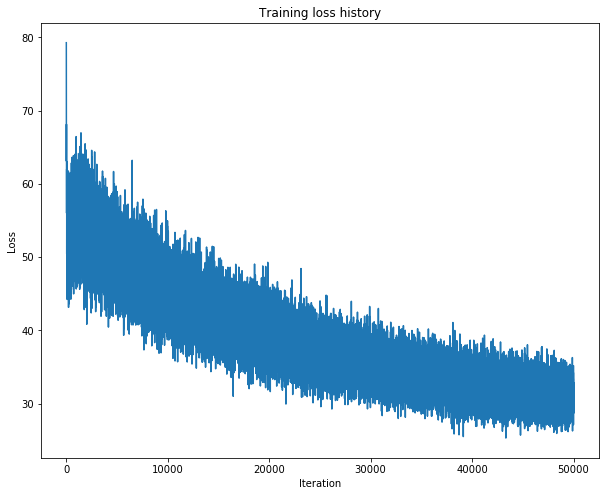

In [12]:
np.random.seed(231)

#small_data = load_coco_data(max_train=50)
small_data = load_coco_data(max_train=82783)
#small_data = load_coco_data(max_train=25000)
small_rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          #hidden_dim=512,
          hidden_dim=1024,
          wordvec_dim=256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
            #'learning_rate': 5e-3,
            'learning_rate': 1e-2,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# Test-time sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

In the file `cs231n/classifiers/rnn.py`, implement the `sample` method for test-time sampling. After doing so, run the following to sample from your overfitted model on both training and validation data. The samples on training data should be very good; the samples on validation data probably won't make sense.

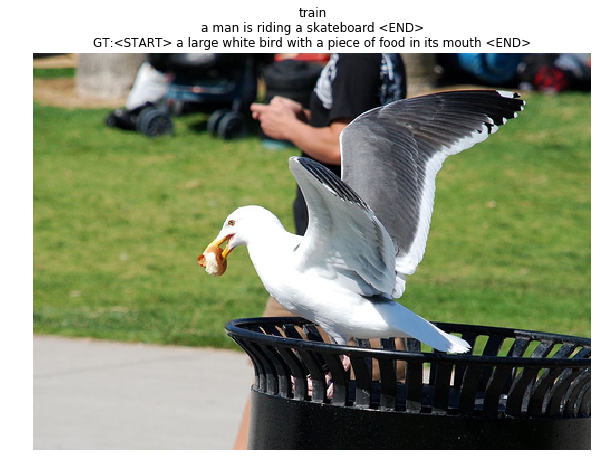

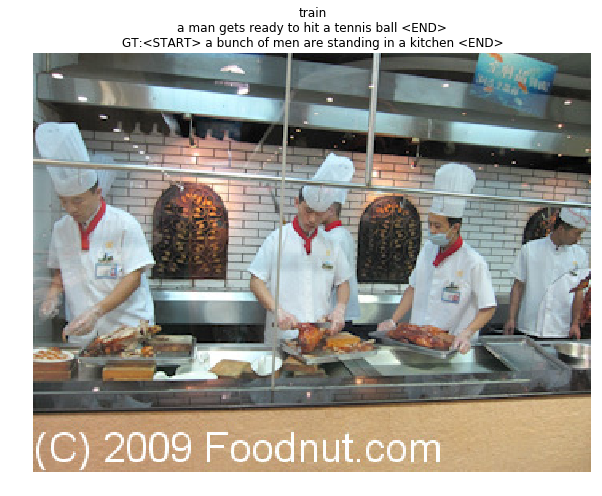

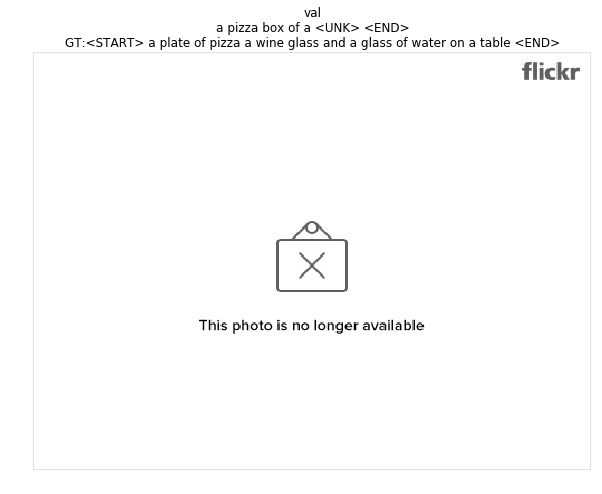

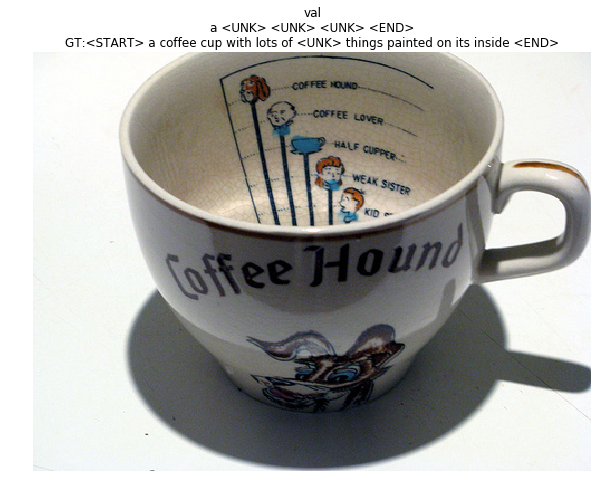

In [14]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()